# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/tasmax-qdc-adjustment-factors-additive_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/tasmax-qdc-additive_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 5
hist_units = "K"
ref_units = "K"
target_units = "C"
output_units = "C"
hist_var = "tasmax"
ref_var = "tasmax"
target_var = "tmax"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/tmax/daily/tmax_AGCD-CSIRO_r005_19100101-20220404_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"


In [5]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [7]:
plot_config = {}
if hist_var in ['tasmax', 'tasmin']:
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var in ['pr']:
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

## Read data

In [8]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)
ds_hist[hist_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<rechunk-merge, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T17:36:46Z altered by CMOR: Treated scalar dime...

In [9]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)
ds_ref[ref_var]

<xarray.DataArray 'tasmax' (time: 10958, lat: 145, lon: 192)>
dask.array<truediv, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...

In [10]:
ds_adjust = xr.open_dataset(adjustment_file)

In [11]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [12]:
ds_target[target_var]

<xarray.DataArray 'tmax' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-tmax, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:45:40 UTC
    analysis_version_number:    2.01
    cell_methods:               time: maximum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily maximum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      C

In [12]:
target_q = utils.get_ref_q(ds_target[target_var], ds_adjust['quantiles'].data)

[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  6min 39.2s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 22.9s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.8s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.7s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 22.3s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.5s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.6s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.4s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.4s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.8s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.1s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.1s


In [13]:
target_q = target_q.compute()

In [13]:
ds_qq = xr.open_dataset(qq_file)

In [14]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [15]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

In [17]:
def quantile_month_plot(da, ax, cmap_type, levels=None, extend='both', point=None, title=None):
    """Create two dimensional month/quantile plot"""
    
    assert cmap_type in ['regular', 'diverging']
    
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose('month', 'quantiles').plot(ax=ax, cmap=cmap, extend=extend, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

In [18]:
def quantile_spatial_plot(
    da, month, cmap_type, lat_bounds=None, lon_bounds=None, levels=None,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
        
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
        
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        **kwargs,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

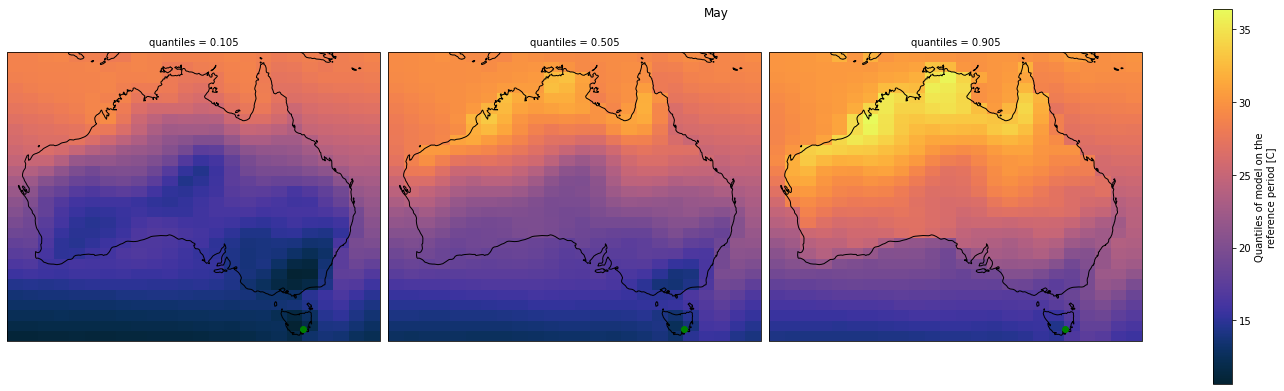

In [19]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        'regular',
        levels=plot_config['general_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

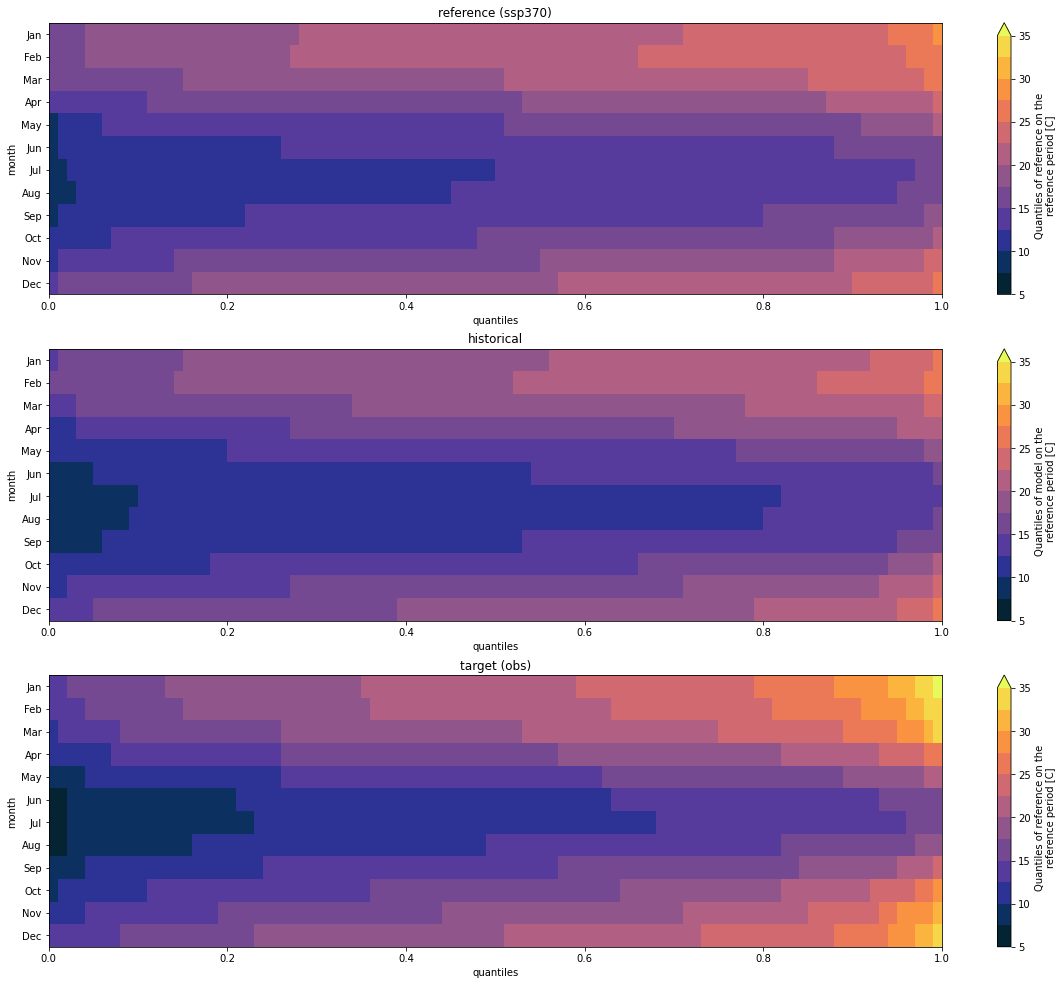

In [27]:
fig = plt.figure(figsize=[20, 17])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax1,
    'regular',
    levels=plot_config['general_levels'],
    title='reference (ssp370)',
    extend='max',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax2,
    'regular',
    levels=plot_config['general_levels'],
    title='historical',
    extend='max',
)

quantile_month_plot(
    target_q,
    ax3,
    'regular',
    levels=plot_config['general_levels'],
    title='target (obs)',
    extend='max',
)

plt.show()

In [20]:
da_hist = ds_hist[hist_var].sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
da_hist = da_hist[da_hist['time'].dt.month == example_month]
df_hist = pd.DataFrame(da_hist.values, columns=[hist_var])

[########################################] | 100% Completed | 13.4s


In [21]:
da_ref = ds_ref[ref_var].sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
da_ref = da_ref[da_ref['time'].dt.month == example_month]
df_ref = pd.DataFrame(da_ref.values, columns=[hist_var])

[########################################] | 100% Completed | 17.9s


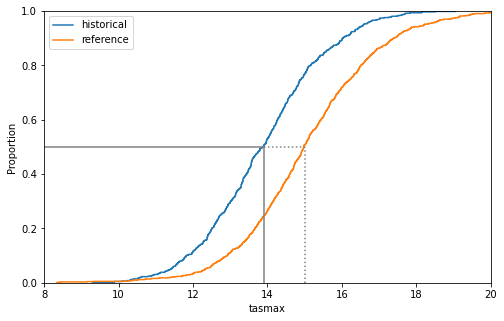

In [110]:
fig = plt.figure(figsize=[8, 5])
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

sns.ecdfplot(ax=ax1, data=df_hist, x=hist_var, color='tab:blue', label='historical')
sns.ecdfplot(ax=ax1, data=df_ref, x=hist_var, color='tab:orange', label='reference')
ax1.legend()
ax1.plot([13.9, 13.9], [0, 0.5], color='0.5')
ax1.plot([5, 13.9], [0.5, 0.5], color='0.5')
ax1.plot([13.9, 15], [0.5, 0.5], color='0.5', linestyle=':')
ax1.plot([15, 15], [0, 0.5], color='0.5', linestyle=':')
ax1.set_xlim(8, 20)
plt.show()

So for a 13.9C day in the observational record, the empirical quantile mapping works as follows:
1. Find the probability that 13.9C is exceeded in the historical data (0.5)
2. Find the temperature corresponding to that probability in the reference data (15C)
3. The additive adjustment factor is the difference between 15C and 13.9C (1.1C)

In other words, for a given temperature in the observational record the xclim software uses `hist_q` to look up the quantile corresponding to that temperature and then uses `af` to find the adjustment factor for the quantile.

[########################################] | 100% Completed |  1min 23.1s
[########################################] | 100% Completed |  6.0s


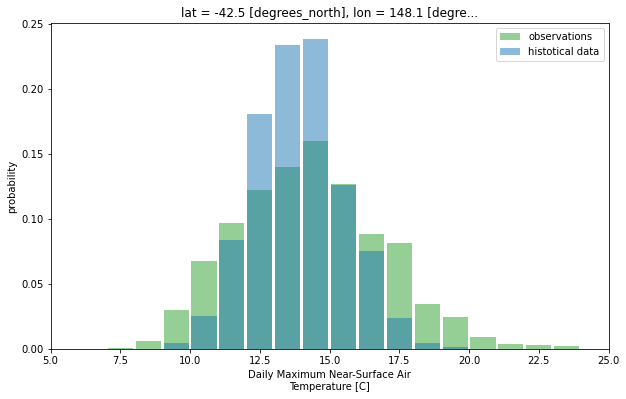

In [22]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}

    
da_target = ds_target[target_var].sel(point_selection, method='nearest')
da_target = da_target[da_target['time'].dt.month == example_month]
da_target.plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)

da_hist.plot.hist(
    bins=bins,
    density=True,
    label='histotical data',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(5, 25)
plt.legend()
plt.show()

An issue here is that the temperature variability at this grid point in the observations is much greater than in the model. This means there are days in the observations that can't be linked to a corresponding historical probability. In this case, the adjustment factor at the first or last quantile (depending on whether it's a very cold or very hot day) is used. 

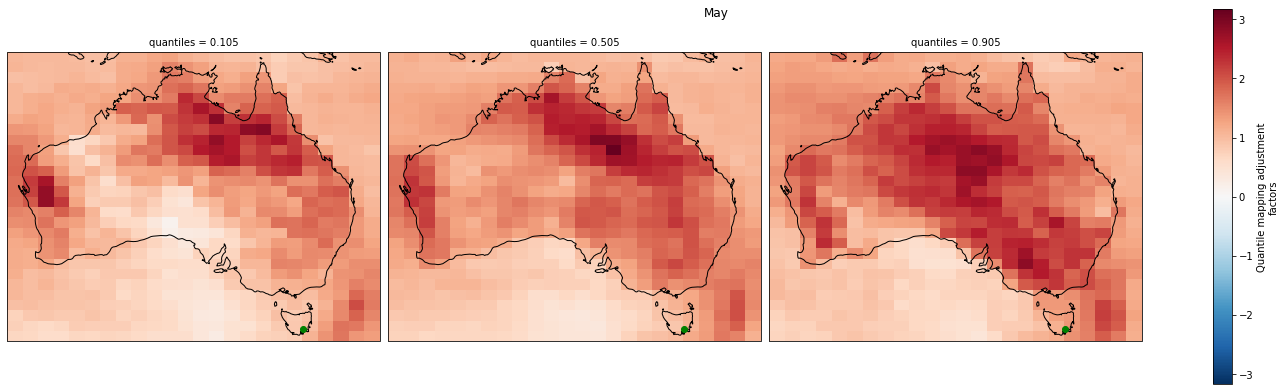

In [28]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        'diverging',
        levels=plot_config['af_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

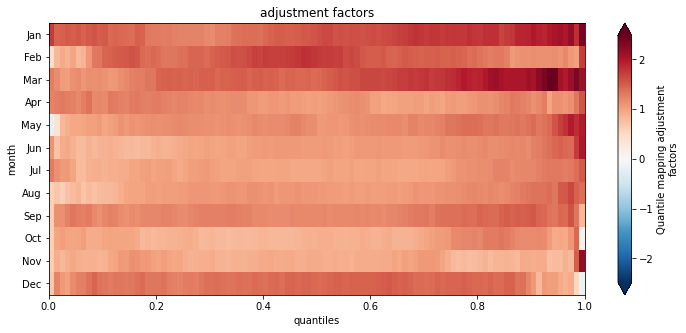

In [29]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors'
)

plt.show()

In [30]:
if len(ds_adjust['lat']) != len(target_q['lat']):
    regridder = xe.Regridder(ds_adjust['af'], target_q, "bilinear")
    af_regridded = regridder(ds_adjust['af'])

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


## QQ-scaled data

In [16]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [17]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)

In [18]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

In [19]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed | 26.1s


In [20]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  8min  6.1s


In [21]:
difference = qq_mean_change - hist_ref_mean_diff

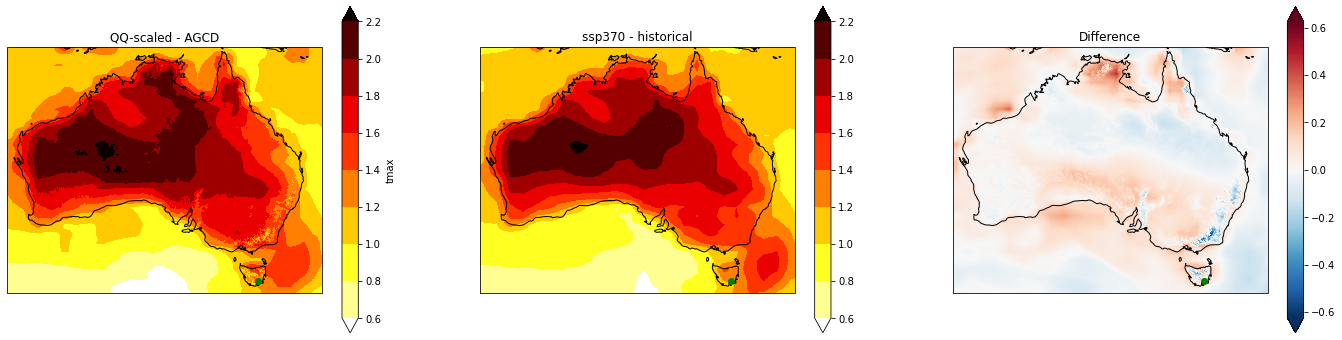

In [29]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=plot_config['difference_levels'],
    extend='both'
)
ax1.set_title('QQ-scaled - AGCD')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=plot_config['difference_levels'],
    extend='both'
)
ax2.set_title('ssp370 - historical')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=None,
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

In [23]:
adjustment_factor =  hist_ref_mean_diff - qq_mean_change
da_qq_adjusted = ds_qq[target_var] + adjustment_factor
qq_clim_adjusted = da_qq_adjusted.mean('time', keep_attrs=True)
qq_adjusted_mean_change = qq_clim_adjusted - target_clim
difference_adjusted = qq_adjusted_mean_change - hist_ref_mean_diff

[########################################] | 100% Completed |  2min 29.2s
[########################################] | 100% Completed |  2min 10.2s


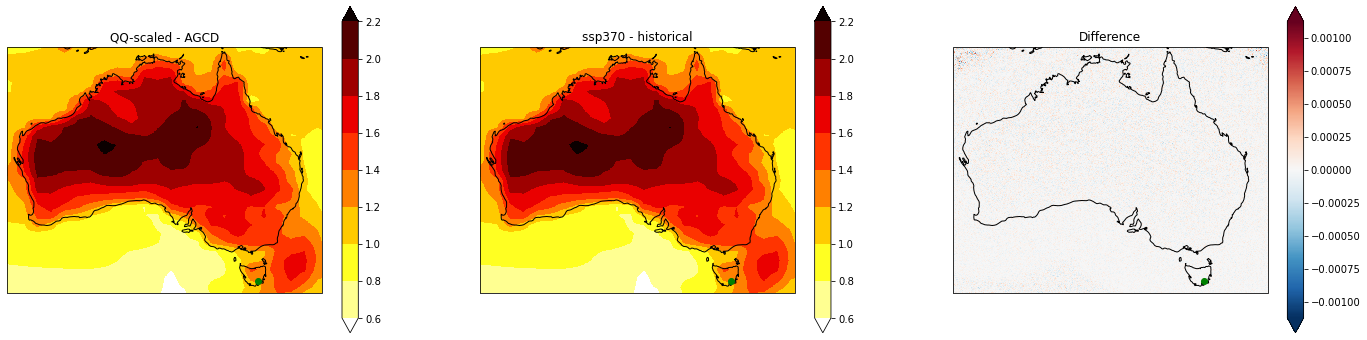

In [30]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
qq_adjusted_mean_change.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=plot_config['difference_levels'],
    extend='both'
)
ax1.set_title('QQ-scaled - AGCD')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=plot_config['difference_levels'],
    extend='both'
)
ax2.set_title('ssp370 - historical')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference_adjusted.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=None,
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  0.6s


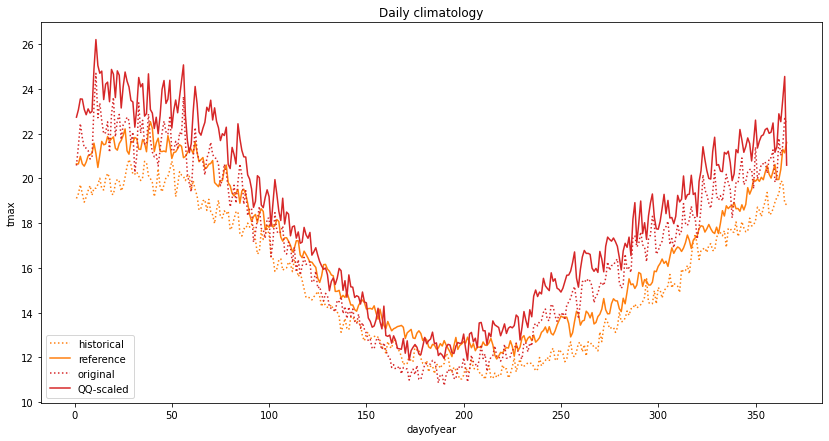

In [32]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[hist_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical", color='tab:orange', linestyle=':')
ds_ref[ref_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="reference", color='tab:orange')
ds_target[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="original", color='tab:red', linestyle=':')
ds_qq[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  0.1s


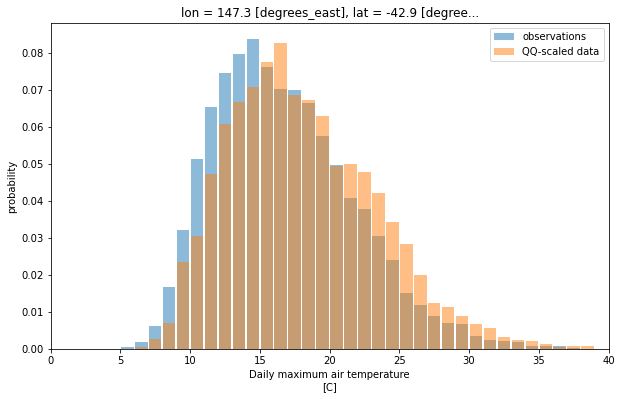

In [26]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_target[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(0, 40)
plt.legend()
plt.show()

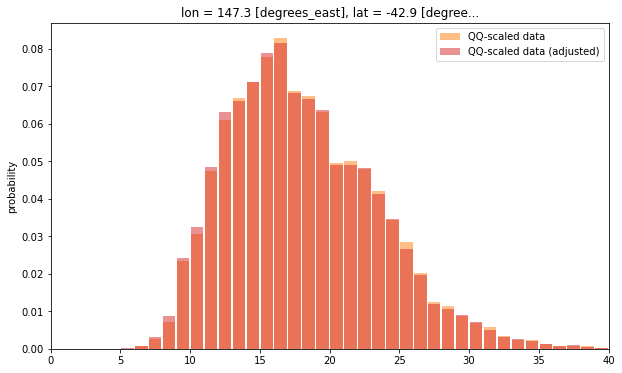

In [27]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
da_qq_adjusted.sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data (adjusted)',
    facecolor='tab:red',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(0, 40)
plt.legend()
plt.show()